In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%load_ext autoreload
%autoreload 2
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from scipy.spatial import distance


In [2]:
img_dir="/media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/"

In [12]:
class detectroninference:
    def __init__(self,model_path,num_cls=1,name_classes=["pepp"]):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml"))
        cfg.DATASETS.TRAIN = ("pep_train",)
        cfg.DATASETS.TEST = ()
        cfg.DATALOADER.NUM_WORKERS = 4
        #cfg.MODEL.WEIGHTS="/media/asad/ADAS_CV/cuc/output_axels2/model_final.pth"
        cfg.MODEL.WEIGHTS=model_path
        cfg["MODEL"]["ANCHOR_GENERATOR"]["ASPECT_RATIOS"][0]=[0.5,1.0,1.5]
        cfg["INPUT"]["RANDOM_FLIP"]="horizontal"
        cfg["INPUT"]["ROTATE"]=[-2.0,2.0]
        cfg["INPUT"]["LIGHT_SCALE"]=2
        cfg["INPUT"]["Brightness_SCALE"]=[0.5,1.5]
        cfg["INPUT"]["Contrast_SCALE"]=[0.5,2]
        cfg["INPUT"]["Saturation_SCALE"]=[0.5,2]
        cfg["MODEL"]["KEYPOINT_ON"]=True
        cfg.MODEL['ROI_KEYPOINT_HEAD']["NUM_KEYPOINTS"]=2
        cfg.SOLVER.IMS_PER_BATCH = 1
        cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
        cfg.SOLVER.CHECKPOINT_PERIOD = 500
        cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
        cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES=1
        cfg.MODEL.RETINANET.NUM_CLASSES=1
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
        print(f"Test Image sizes {cfg.INPUT.MIN_SIZE_TEST},{cfg.INPUT.MAX_SIZE_TEST}")
        self.predictor = DefaultPredictor(cfg)
        self.pepp_metadata = MetadataCatalog.get("pepp").set(thing_classes=name_classes)
        self.pepp_metadata = MetadataCatalog.get("pep").set(keypoint_names=["head","tail"])
        self.pepp_metadata = MetadataCatalog.get("pep").set(keypoint_flip_map=[("head","head"),("tail","tail")])
        self.pepp_metadata = MetadataCatalog.get("pep").set(keypoint_connection_rules=[("head","tail",(0,255,255))])
        
    
    def apply_mask(self,mask,img):
        all_masks=np.zeros(mask.shape,dtype=np.uint8)
        all_patches=np.zeros((*mask.shape,3),dtype=np.uint8)
        """Apply the given mask to the image."""
        for i in range(all_masks.shape[0]):
                all_masks[i][:, :] = np.where(mask[i] == True,255,0)
                for j in range(3):
                    all_patches[i][:, :,j] = np.where(mask[i] == True,img[:,:,j],0)
        return all_masks,all_patches


    def pred(self,img):
        orig_img=img.copy()
        height,width=img.shape[:2]
        outputs = self.predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(img[:, :, ::-1],
                        metadata=self.pepp_metadata, 
                        scale=0.3, 
                        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        #print(outputs["instances"].to("cpu"))
        #print(outputs["instances"].to("cpu").pred_keypoints)
        #print(outputs["instances"].to("cpu").pred_masks.shape)
        masks = np.asarray(outputs["instances"].to("cpu").pred_masks)
        masks,patches=self.apply_mask(masks,orig_img)
        classes=outputs["instances"].pred_classes.to("cpu").numpy()
        boxes=(outputs["instances"].pred_boxes.to("cpu").tensor.numpy())
        #print(c)
        return out.get_image()[:, :, ::-1],masks,patches,boxes,classes,outputs["instances"].scores.to("cpu").numpy()


In [13]:
model_path="/media/asad/ADAS_CV/vegs_results/models/pepper/keypoints/model_final.pth"
img_path="/media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train"

In [14]:
pepp=detectroninference(model_path)

Test Image sizes 800,1333


Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0008.jpg Count 1
Resized Image shape passed to Predictor is torch.Size([3, 800, 1026])


/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/aten/sr

Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0009.jpg Count 2
Resized Image shape passed to Predictor is torch.Size([3, 800, 935])
Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0010.jpg Count 3
Resized Image shape passed to Predictor is torch.Size([3, 414, 1333])
Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0011.jpg Count 4
Resized Image shape passed to Predictor is torch.Size([3, 800, 1115])
Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0026.jpg Count 5
Resized Image shape passed to Predictor is torch.Size([3, 800, 1241])
Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0038.jpg Count 6
Resized Image shape passed to Predictor is torch.Size([3, 800, 958])
Processing image /media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/train/0048.jpg Count 7
Resized Image shape passed to Predictor is torch.Size([3, 800, 1173])


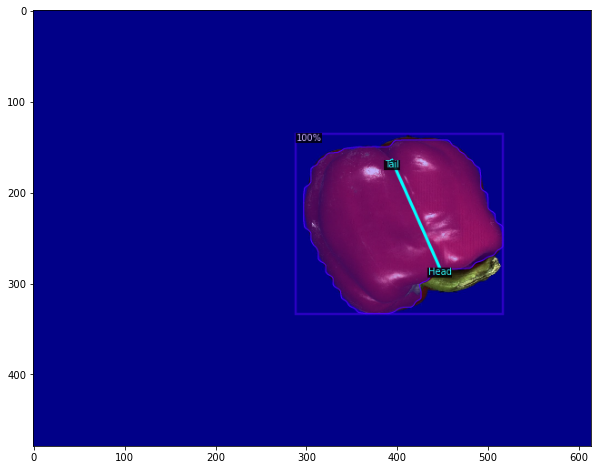

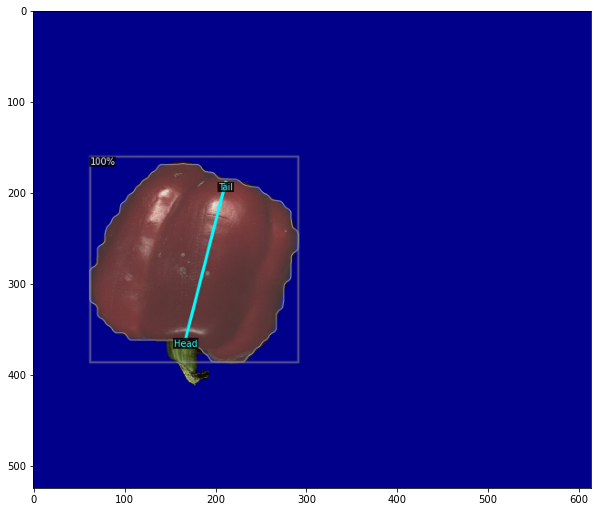

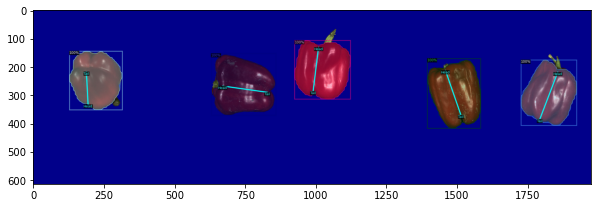

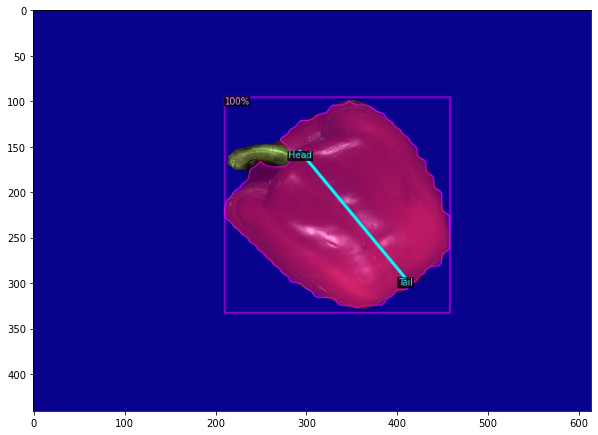

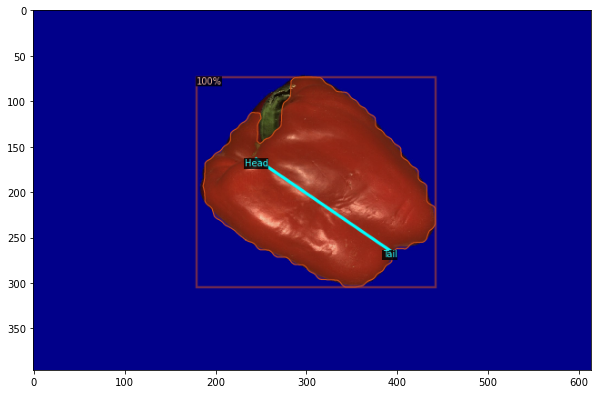

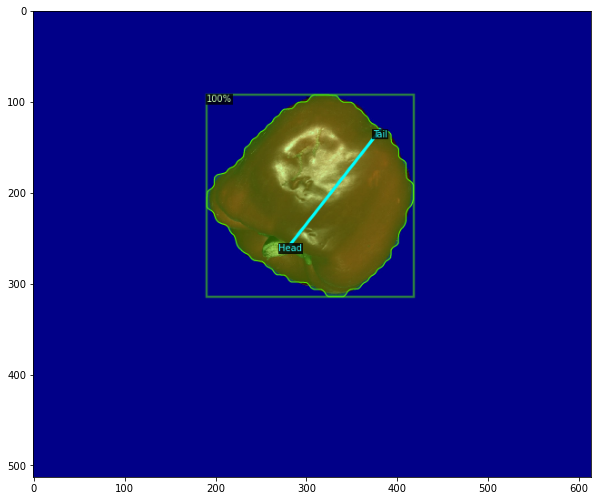

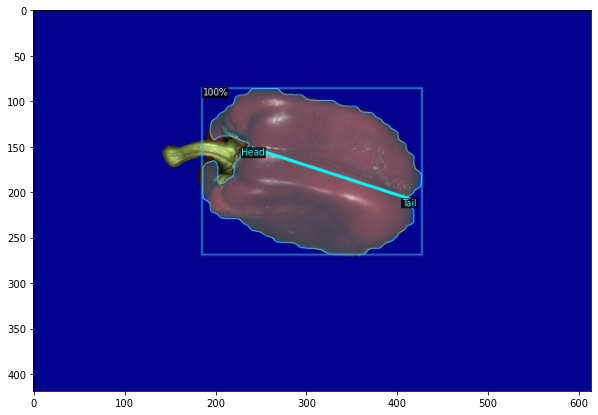

In [5]:
count=0
for file_index,filename in enumerate(os.listdir(img_path)):
    if filename.endswith(".json") or filename.endswith(".jpg.png"):
        continue 
    f_p=os.path.join(img_path,filename)
    #print(f_p)
    img=cv2.imread(f_p)
    if img is not None:
        count+=1
        print(f"Processing image {f_p} Count {count}")
        detected_pepp,all_masks,all_patches,boxes,*_=pepp.pred(img)
        fig=plt.figure(figsize=(10,10))
        plt.imshow(detected_pepp[...,::-1])
        